# animation

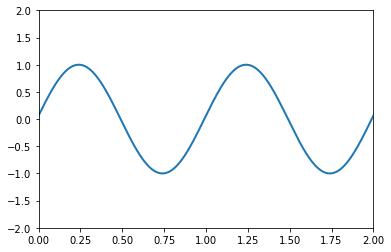

In [2]:
# http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('./mp4/basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

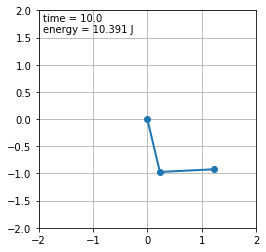

In [4]:
# http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

"""
General Numerical Solver for the 1D Time-Dependent Schrodinger's equation.

adapted from code at http://matplotlib.sourceforge.net/examples/animation/double_pendulum_animated.py

Double pendulum formula translated from the C code at
http://www.physics.usyd.edu.au/~wheat/dpend_html/solve_dpend.c

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class DoublePendulum:
    """Double Pendulum Class

    init_state is [theta1, omega1, theta2, omega2] in degrees,
    where theta1, omega1 is the angular position and velocity of the first
    pendulum arm, and theta2, omega2 is that of the second pendulum arm
    """
    def __init__(self,
                 init_state = [120, 0, -20, 0],
                 L1=1.0,  # length of pendulum 1 in m
                 L2=1.0,  # length of pendulum 2 in m
                 M1=1.0,  # mass of pendulum 1 in kg
                 M2=1.0,  # mass of pendulum 2 in kg
                 G=9.8,  # acceleration due to gravity, in m/s^2
                 origin=(0, 0)): 
        self.init_state = np.asarray(init_state, dtype='float')
        self.params = (L1, L2, M1, M2, G)
        self.origin = origin
        self.time_elapsed = 0

        self.state = self.init_state * np.pi / 180.
    
    def position(self):
        """compute the current x,y positions of the pendulum arms"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([self.origin[0],
                       L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([self.origin[1],
                       -L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        return (x, y)

    def energy(self):
        """compute the energy of the current state"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([-L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        vx = np.cumsum([L1 * self.state[1] * cos(self.state[0]),
                        L2 * self.state[3] * cos(self.state[2])])
        vy = np.cumsum([L1 * self.state[1] * sin(self.state[0]),
                        L2 * self.state[3] * sin(self.state[2])])

        U = G * (M1 * y[0] + M2 * y[1])
        K = 0.5 * (M1 * np.dot(vx, vx) + M2 * np.dot(vy, vy))

        return U + K

    def dstate_dt(self, state, t):
        """compute the derivative of the given state"""
        (M1, M2, L1, L2, G) = self.params

        dydx = np.zeros_like(state)
        dydx[0] = state[1]
        dydx[2] = state[3]

        cos_delta = cos(state[2] - state[0])
        sin_delta = sin(state[2] - state[0])

        den1 = (M1 + M2) * L1 - M2 * L1 * cos_delta * cos_delta
        dydx[1] = (M2 * L1 * state[1] * state[1] * sin_delta * cos_delta
                   + M2 * G * sin(state[2]) * cos_delta
                   + M2 * L2 * state[3] * state[3] * sin_delta
                   - (M1 + M2) * G * sin(state[0])) / den1

        den2 = (L2 / L1) * den1
        dydx[3] = (-M2 * L2 * state[3] * state[3] * sin_delta * cos_delta
                   + (M1 + M2) * G * sin(state[0]) * cos_delta
                   - (M1 + M2) * L1 * state[1] * state[1] * sin_delta
                   - (M1 + M2) * G * sin(state[2])) / den2
        
        return dydx

    def step(self, dt):
        """execute one time step of length dt and update state"""
        self.state = integrate.odeint(self.dstate_dt, self.state, [0, dt])[1]
        self.time_elapsed += dt

#------------------------------------------------------------
# set up initial state and global variables
pendulum = DoublePendulum([180., 0.0, -20., 0.0])
dt = 1./30 # 30 fps

#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text

def animate(i):
    """perform animation step"""
    global pendulum, dt
    pendulum.step(dt)
    
    line.set_data(*pendulum.position())
    time_text.set_text('time = %.1f' % pendulum.time_elapsed)
    energy_text.set_text('energy = %.3f J' % pendulum.energy())
    return line, time_text, energy_text

# choose the interval based on dt and the time to animate one step
from time import time
t0 = time()
animate(0)
t1 = time()
interval = 1000 * dt - (t1 - t0)

ani = animation.FuncAnimation(fig, animate, frames=300,
                              interval=interval, blit=True, init_func=init)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
ani.save('./mp4/double_pendulum.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

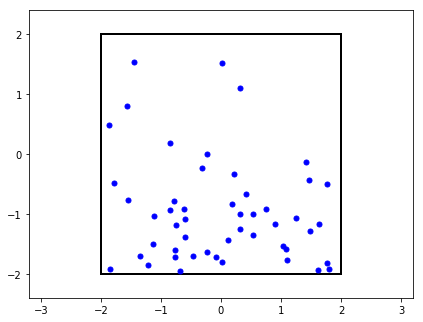

In [5]:
# http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

"""
Animation of Elastic collisions with Gravity

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""
import numpy as np
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class ParticleBox:
    """Orbits class
    
    init_state is an [N x 4] array, where N is the number of particles:
       [[x1, y1, vx1, vy1],
        [x2, y2, vx2, vy2],
        ...               ]

    bounds is the size of the box: [xmin, xmax, ymin, ymax]
    """
    def __init__(self,
                 init_state = [[1, 0, 0, -1],
                               [-0.5, 0.5, 0.5, 0.5],
                               [-0.5, -0.5, -0.5, 0.5]],
                 bounds = [-2, 2, -2, 2],
                 size = 0.04,
                 M = 0.05,
                 G = 9.8):
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.size = size
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds
        self.G = G

    def step(self, dt):
        """step once by dt seconds"""
        self.time_elapsed += dt
        
        # update positions
        self.state[:, :2] += dt * self.state[:, 2:]

        # find pairs of particles undergoing a collision
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.size)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # update velocities of colliding pairs
        for i1, i2 in zip(ind1, ind2):
            # mass
            m1 = self.M[i1]
            m2 = self.M[i2]

            # location vector
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            # velocity vector
            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            # relative location & velocity vectors
            r_rel = r1 - r2
            v_rel = v1 - v2

            # momentum vector of the center of mass
            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            # collisions of spheres reflect v_rel over r_rel
            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # assign new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2) 

        # check for crossing boundary
        crossed_x1 = (self.state[:, 0] < self.bounds[0] + self.size)
        crossed_x2 = (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y1 = (self.state[:, 1] < self.bounds[2] + self.size)
        crossed_y2 = (self.state[:, 1] > self.bounds[3] - self.size)

        self.state[crossed_x1, 0] = self.bounds[0] + self.size
        self.state[crossed_x2, 0] = self.bounds[1] - self.size

        self.state[crossed_y1, 1] = self.bounds[2] + self.size
        self.state[crossed_y2, 1] = self.bounds[3] - self.size

        self.state[crossed_x1 | crossed_x2, 2] *= -1
        self.state[crossed_y1 | crossed_y2, 3] *= -1

        # add gravity
        self.state[:, 3] -= self.M * self.G * dt


#------------------------------------------------------------
# set up initial state
np.random.seed(0)
init_state = -0.5 + np.random.random((50, 4))
init_state[:, :2] *= 3.9

box = ParticleBox(init_state, size=0.04)
dt = 1. / 30 # 30fps


#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-3.2, 3.2), ylim=(-2.4, 2.4))

# particles holds the locations of the particles
particles, = ax.plot([], [], 'bo', ms=6)

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

def init():
    """initialize animation"""
    global box, rect
    particles.set_data([], [])
    rect.set_edgecolor('none')
    return particles, rect

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig
    box.step(dt)

    ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
             / np.diff(ax.get_xbound())[0])
    
    # update pieces of the animation
    rect.set_edgecolor('k')
    particles.set_data(box.state[:, 0], box.state[:, 1])
    particles.set_markersize(ms)
    return particles, rect

ani = animation.FuncAnimation(fig, animate, frames=600,
                              interval=10, blit=True, init_func=init)


# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
ani.save('./mp4/particle_box.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

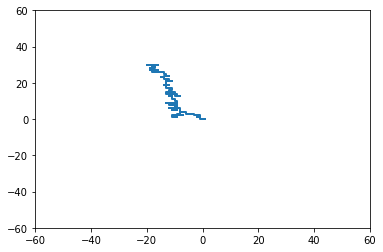

In [26]:
# 2D simple random walk

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

np.random.seed(337)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-60, 60), ylim=(-60, 60))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

start_position = np.array([0, 0]) 
x_history = [0]
y_history = [0]

# animation function.  This is called sequentially
def animate(i):
    global start_position, x_history, y_history
    
    if np.random.uniform(0., 1.) > 0.75:
        end_position = start_position + np.array([1, 0]) 
    elif np.random.uniform(0., 1.) > 0.50:
        end_position = start_position + np.array([-1, 0]) 
    elif np.random.uniform(0., 1.) > 0.25:
        end_position = start_position + np.array([0, 1]) 
    else:
        end_position = start_position + np.array([0, -1]) 
        
    x_history.append(end_position[0])
    y_history.append(end_position[1])
        
    line.set_data(x_history, y_history)
    
    start_position = end_position
        
    return line,

# call the animator.  
# We've chosen a 200 frame animation with a 20ms delay between frames.
# blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  
# This requires ffmpeg or mencoder to be installed.

# https://www.videosurveillance.com/tech/frame-rate.asp
# 30 fps means the camera captured 30 frames in a single second of video

# The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  
# You may need to adjust this for your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('./mp4/2d_simple_random_walk.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

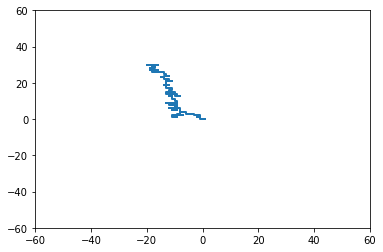

In [27]:
%run 2d_simple_random_walk.py

In [21]:
a = [1]
b, = a
print(b)

1


In [22]:
a = [1]
b = a[0]
print(b)

1


In [23]:
a = 1
b = a,
print(b)

(1,)
